In [122]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 데이터 로드

In [123]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# Mecab 토크나이저 초기화

In [124]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train,y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

index_to_word = {index:word for word, index in word_to_index.items()}

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

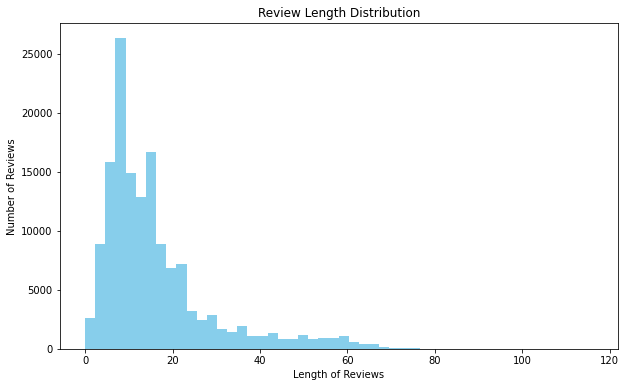

In [125]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# 3) 데이터 분석 및 가공
# 토큰 수와 리뷰 길이 분포를 시각화하여 데이터 이해
review_lengths = [len(tokens) for tokens in X_train]
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50, color='skyblue')
plt.title('Review Length Distribution')
plt.xlabel('Length of Reviews')
plt.ylabel('Number of Reviews')
plt.show()

In [126]:
# 데이터의 최대 길이를 설정하고 길이 분포를 기반으로 적절한 최대 길이 결정
# 문장길이중 90% 커버해주는 값을 리턴, 33이 90%을 커버해주는 문장길이다

max_len = np.percentile(review_lengths, 90)  # 상위 90% 커버 
print("Chosen maximum length:", max_len)

Chosen maximum length: 33.0


In [127]:
# 4) 모델 구성 및 validation set 구성
model = Sequential([
    Embedding(input_dim=len(word_to_index), output_dim=100, input_length=int(max_len)),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

# validation set 준비
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [120]:
#5) 모델 훈련 개시
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 입력 데이터를 NumPy 배열 형식으로 변환하고 시퀀스를 패딩 처리합니다.
# 'post' 옵션을 사용하여 필요한 경우 시퀀스 끝에 패딩(0)을 추가합니다.
X_train_padded = pad_sequences(X_train, maxlen=int(max_len), padding='post', dtype='int32')
X_val_padded = pad_sequences(X_val, maxlen=int(max_len), padding='post', dtype='int32')

# 패딩 처리된 데이터를 NumPy 배열로 변환합니다.
X_train_padded = np.array(X_train_padded)
X_val_padded = np.array(X_val_padded)
y_train = np.array(y_train)
y_val = np.array(y_val)

# 모델 구조를 설정합니다.
# optimizer로 'adam'을 사용하고, 손실 함수로는 'binary_crossentropy'를 사용합니다.
# 'accuracy' 메트릭을 사용하여 훈련 과정에서 정확도를 측정합니다.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델을 훈련합니다.
# X_train_padded와 y_train을 사용하여 모델을 훈련하고, X_val_padded와 y_val을 사용하여 검증합니다.
# epochs는 10으로 설정하여 총 10번의 에포크로 훈련을 진행합니다.
# batch_size는 64로 설정하여 한 번에 64개의 샘플을 처리합니다.
# EarlyStopping은 val_loss의 개선이 멈추면 훈련을 중단하도록 하며, patience는 4로 설정합니다.
# ModelCheckpoint를 사용하여 검증 정확도(val_accuracy)가 개선될 때마다 모델을 저장합니다.
history = model.fit(
    X_train_padded, y_train, 
    validation_data=(X_val_padded, y_val), 
    epochs=10, batch_size=128, 
    callbacks=[es, mc]
)

Epoch 1/10
914/914 [==============================] - 10s 9ms/step - loss: 0.3966 - accuracy: 0.8181 - val_loss: 0.3521 - val_accuracy: 0.8495

Epoch 00001: val_accuracy did not improve from 0.86144
Epoch 2/10
914/914 [==============================] - 7s 8ms/step - loss: 0.3112 - accuracy: 0.8661 - val_loss: 0.3250 - val_accuracy: 0.8585

Epoch 00002: val_accuracy did not improve from 0.86144
Epoch 3/10
914/914 [==============================] - 7s 8ms/step - loss: 0.2706 - accuracy: 0.8858 - val_loss: 0.3445 - val_accuracy: 0.8574

Epoch 00003: val_accuracy did not improve from 0.86144
Epoch 4/10
914/914 [==============================] - 7s 8ms/step - loss: 0.2384 - accuracy: 0.9005 - val_loss: 0.3494 - val_accuracy: 0.8577

Epoch 00004: val_accuracy did not improve from 0.86144
Epoch 5/10
914/914 [==============================] - 7s 8ms/step - loss: 0.2090 - accuracy: 0.9144 - val_loss: 0.3874 - val_accuracy: 0.8560

Epoch 00005: val_accuracy did not improve from 0.86144
Epoch 6/1

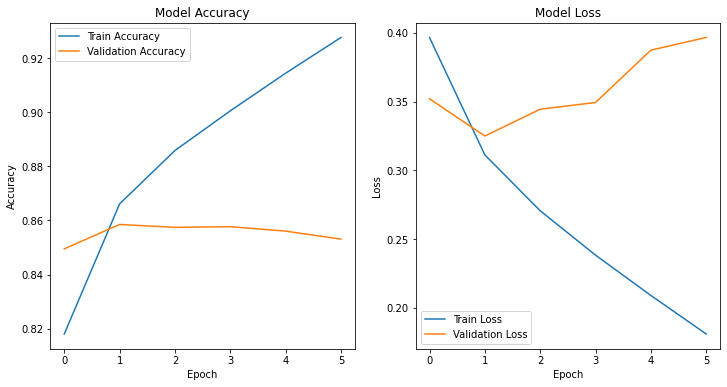

In [121]:
# 6) Loss, Accuracy 그래프 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [115]:
# 7) 학습된 Embedding 레이어 분석
weights = model.layers[0].get_weights()[0]
print("Shape of the embedding weights:", weights.shape)


Shape of the embedding weights: (9997, 100)


8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.


In [130]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['영화']
vector


array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [131]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word_vectors.wv.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

배운 점 : 전체 프로세스 이해
아쉬운 점 : 시간이 부족하여 디테일한 이해도 부족
느낀 점 : 시각이 촉박했다
어려웠던 점 : 프로그래밍 부분에 막혀 자세한 연구가 어려웠다.